In [1]:
import pandas as pd
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator as kmf
import matplotlib.pyplot as plt
from lifelines.statistics import logrank_test
import matplotlib.patches as mpatches

In [4]:
selected_cell = 'Fibroblasts'

In [5]:
estimation = pd.read_csv('GSE14520.Non-immune.csv',index_col=0)
estimation.head()

,Immune cluster,Hepatocytes,Fibroblasts,Endothelial Cells,Bi-Potent Cells,P-value,Correlation,RMSE
Mixture,,,,,,,,
GSM362947,0.0,0.857934,0.040412,0.065746,0.035908,0,0.292077,1.462487
GSM362948,0.0,0.774579,0.082644,0.048744,0.094033,0,0.705280,0.905997
GSM362949,0.0,0.679952,0.078860,0.058294,0.182895,0,0.662427,0.882807
GSM362950,0.0,0.701245,0.103513,0.040908,0.154334,0,0.740078,0.792355
GSM362951,0.0,0.891538,0.040139,0.043650,0.024673,0,0.871067,0.761878


In [6]:
survival_data = pd.read_csv('GSE14520.Survival.csv',index_col=0)
survival_data.head()

,OS_E,OS,DFS_E,DFS
GSM,,,,
GSM363205,0,58.0,0,58.0
GSM363115,0,66.6,0,66.6
GSM362970,0,67.3,0,67.3
GSM363354,1,10.4,1,10.4
GSM363039,0,52.8,0,52.8


In [7]:
dfs_data = survival_data.filter(['DFS_E', 'DFS'])
dfs_data = dfs_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
dfs_data['DFS_E'] = [binary[event] for event in dfs_data['DFS_E']]
dfs_data['DFS_T'] = [time for time in dfs_data['DFS']]
dfs_data.head()

,DFS_E,DFS,DFS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [8]:
survival_test = estimation.merge(dfs_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,Immune cluster,Hepatocytes,Fibroblasts,Endothelial Cells,Bi-Potent Cells,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM362947,0.0,0.857934,0.040412,0.065746,0.035908,0,0.292077,1.462487,True,50.0,50.0
GSM362948,0.0,0.774579,0.082644,0.048744,0.094033,0,0.705280,0.905997,True,8.8,8.8
GSM362949,0.0,0.679952,0.078860,0.058294,0.182895,0,0.662427,0.882807,True,18.2,18.2
GSM362950,0.0,0.701245,0.103513,0.040908,0.154334,0,0.740078,0.792355,True,30.1,30.1
GSM362952,0.0,0.896763,0.015916,0.063131,0.024190,0,0.918001,0.674010,False,54.3,54.3


In [9]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder.head()

,Immune cluster,Hepatocytes,Fibroblasts,Endothelial Cells,Bi-Potent Cells,P-value,Correlation,RMSE,DFS_E,DFS,DFS_T
GSM363393,0.000000,0.202565,0.548697,0.248738,0.000000,0,0.232372,1.026100,True,4.0,4.0
GSM363054,0.203565,0.119961,0.416918,0.124181,0.135375,0,0.032486,1.066361,False,53.8,53.8
GSM363055,0.000000,0.323901,0.368447,0.101022,0.206630,0,0.259914,1.027828,False,7.3,7.3
GSM363428,0.000000,0.278028,0.334091,0.087206,0.300674,0,0.022342,1.137977,True,3.8,3.8
GSM363184,0.356981,0.000000,0.264403,0.014397,0.364220,0,0.093688,1.042946,False,16.3,16.3


In [10]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['DFS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['DFS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [11]:
optimization = optimization.dropna()
optimization = optimization.sort_values('Log Rank Test')
optimization = int(optimization.iloc[0].name)
optimization

87

In [12]:
dfs_cut_level = survival_reorder[selected_cell][optimization]
dfs_cut_level

0.0490625175379442

In [13]:
E = list(survival_reorder['DFS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['DFS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.00416

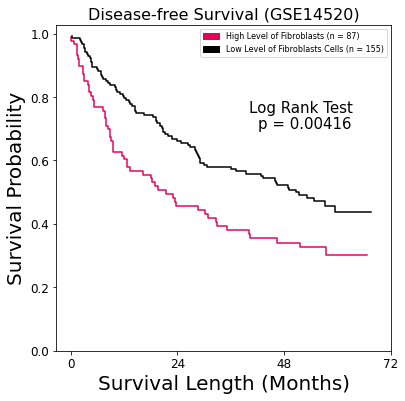

In [14]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#e6005c')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#e6005c',label='High Level of Fibroblasts (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Fibroblasts Cells (n = %s)'%len(E_low))
plt.text(40,0.75, 'Log Rank Test',fontsize=15)
plt.text(42,0.7, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Disease-free Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.DFS.pdf'%selected_cell,format='pdf')

In [15]:
os_data = survival_data.filter(['OS_E', 'OS'])
os_data = os_data.dropna(axis=0,how='any')
binary = {1:True,0:False}
os_data['OS_E'] = [binary[event] for event in os_data['OS_E']]
os_data['OS_T'] = [time for time in os_data['OS']]
os_data.head()

,OS_E,OS,OS_T
GSM,,,
GSM363205,False,58.0,58.0
GSM363115,False,66.6,66.6
GSM362970,False,67.3,67.3
GSM363354,True,10.4,10.4
GSM363039,False,52.8,52.8


In [16]:
survival_test = estimation.merge(os_data,left_index=True,right_index=True,how='inner')
survival_test.head()

,Immune cluster,Hepatocytes,Fibroblasts,Endothelial Cells,Bi-Potent Cells,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM362947,0.0,0.857934,0.040412,0.065746,0.035908,0,0.292077,1.462487,True,59.2,59.2
GSM362948,0.0,0.774579,0.082644,0.048744,0.094033,0,0.705280,0.905997,False,61.4,61.4
GSM362949,0.0,0.679952,0.078860,0.058294,0.182895,0,0.662427,0.882807,True,18.2,18.2
GSM362950,0.0,0.701245,0.103513,0.040908,0.154334,0,0.740078,0.792355,False,57.5,57.5
GSM362952,0.0,0.896763,0.015916,0.063131,0.024190,0,0.918001,0.674010,False,54.3,54.3


In [17]:
survival_reorder = survival_test.sort_values(selected_cell,axis=0,ascending=False)
survival_reorder

,Immune cluster,Hepatocytes,Fibroblasts,Endothelial Cells,Bi-Potent Cells,P-value,Correlation,RMSE,OS_E,OS,OS_T
GSM363393,0.000000,0.202565,0.548697,0.248738,0.000000,0,0.232372,1.026100,True,4.0,4.0
GSM363054,0.203565,0.119961,0.416918,0.124181,0.135375,0,0.032486,1.066361,False,53.8,53.8
GSM363055,0.000000,0.323901,0.368447,0.101022,0.206630,0,0.259914,1.027828,False,7.3,7.3
GSM363428,0.000000,0.278028,0.334091,0.087206,0.300674,0,0.022342,1.137977,True,3.8,3.8
GSM363184,0.356981,0.000000,0.264403,0.014397,0.364220,0,0.093688,1.042946,False,16.3,16.3
...,...,...,...,...,...,...,...,...,...,...,...
GSM363182,0.000000,0.938531,0.004053,0.010028,0.047389,0,0.539124,1.302356,False,52.7,52.7
GSM363232,0.028019,0.895510,0.002794,0.029290,0.044386,0,0.873888,0.763418,False,57.9,57.9
GSM363420,0.023158,0.841012,0.001193,0.037699,0.096938,0,0.802157,0.830639,True,7.3,7.3
GSM363205,0.000000,0.899526,0.000248,0.081007,0.019219,0,0.896000,0.723848,False,58.0,58.0


In [18]:
running_length = len(survival_reorder)

logrank_tests = []
cut_points = []

for i in range(running_length):
    cut_point = int(i+1)
    E = list(survival_reorder['OS_E'])
    mid_point = int(len(E)/2)
    E_high = E[:cut_point]
    E_low = E[cut_point:]
    S = list(survival_reorder['OS_T'])
    S_high = S[:cut_point]
    S_low = S[cut_point:]
    results = logrank_test(S_high,S_low,E_high,E_low)
    p = results.p_value
    cut_points.append(cut_point)
    logrank_tests.append(p)

optimization = pd.DataFrame(logrank_tests,index=cut_points,columns=['Log Rank Test'])

In [23]:
#optimization = optimization.dropna()
#optimization = optimization.sort_values('Log Rank Test')
#optimization = int(optimization.iloc[0].name)
optimization = int(len(E)/2)

In [24]:
os_cut_level = survival_reorder[selected_cell][optimization]
os_cut_level

0.037574839266032

In [25]:
E = list(survival_reorder['OS_E'])
cut_point = optimization
E_high = E[:cut_point]
E_low = E[cut_point:]
S = list(survival_reorder['OS_T'])
S_high = S[:cut_point]
S_low = S[cut_point:]
results = logrank_test(S_high,S_low,E_high,E_low)
p = results.p_value
p = round(p,5)
p

0.46564

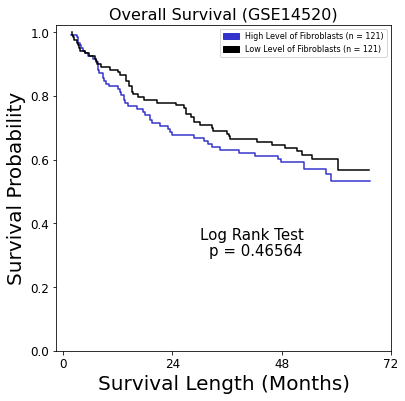

In [26]:
plt.figure(figsize=(6,6))
t,s = kmf(E_high, S_high)
plt.step(t,s,c='#3333cc')
t,s = kmf(E_low, S_low)
plt.step(t,s,c='k')
plt.xticks(np.arange(0,73,24),fontsize=12)
plt.yticks(np.arange(0,1.1,0.2),fontsize=12)
plt.xlabel('Survival Length (Months)', fontsize=20)
plt.ylabel('Survival Probability',fontsize=20)
high_patch = mpatches.Patch(color='#3333cc',label='High Level of Fibroblasts (n = %s)'%len(E_high))
low_patch = mpatches.Patch(color='k',label='Low Level of Fibroblasts (n = %s)'%len(E_low))
plt.text(30,0.35, 'Log Rank Test',fontsize=15)
plt.text(32,0.3, 'p = %s'%p,fontsize=15)
plt.legend(handles=[high_patch,low_patch],fontsize=8)
plt.title('Overall Survival (GSE14520)',fontsize=16)
plt.savefig('GSE14520.%s.OS.pdf'%selected_cell,format='pdf')

In [27]:
estimation = estimation.sort_values(selected_cell,ascending=False)
x = []
y = []
for key,value in enumerate(estimation[selected_cell]):
    x.append(key)
    y.append(value)

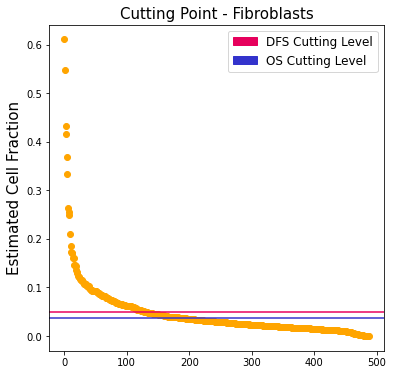

In [28]:
plt.figure(figsize=(6,6))
plt.scatter(x,y,color='orange')
plt.axhline(y=os_cut_level, xmin=0, xmax=100,color='#3333cc')
plt.axhline(y=dfs_cut_level, xmin=0, xmax=100,color='#e6005c')
plt.ylabel('Estimated Cell Fraction',fontsize=15)
plt.title('Cutting Point - Fibroblasts',fontsize=15)
dfs_patch = mpatches.Patch(color='#e6005c',label='DFS Cutting Level')
os_patch = mpatches.Patch(color='#3333cc',label='OS Cutting Level')
plt.legend(handles=[dfs_patch,os_patch],fontsize=12)
plt.savefig('Cutting_Point.%s'%selected_cell,format='pdf')